# Plot growth data
This R Jupyter notebook uses ggplot2 to plot the growth curve data.

Load R packages:

In [1]:
options(warn=-1)

library("tidyverse")
library("cowplot")
library("IRdisplay")

sessionInfo()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 14.04.5 LTS

Matrix products: default
BLAS/LAPACK: /fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] IRdisplay_0.7.0 cowplot_0.9.3   forcats_0.3.0   stringr_1.3.1  
 [5] dplyr_0.7.8     purrr_0.2.5     readr_1.1.1     tidyr_0.8.1    
 [9] tibble_1.4.2    ggplot2_3.1.1   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.4 repr_0.19.1.9000 h

Color-blind palette:

In [2]:
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73",
               "#D55E00", "#CC79A7")

Plot axes labels in nice scientific notation:

In [3]:
fancy_scientific <- function(x, parse.str=TRUE, digits=NULL) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  # if `parse.str` is TRUE, then we parse the string into an expression
  # `digits` indicates how many digits to include
  x %>% format(scientific=TRUE, digits=digits) %>% gsub("^0e\\+00","0", .) %>%
    gsub("^1e\\+00", "1", .) %>% gsub("^(.*)e", "'\\1'e", .) %>% 
    gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% {if (parse.str) parse(text=.) else .}
}

Function to save and show plots:

In [4]:
figsdir <- "results/growth_data"
dir.create(figsdir, showWarnings=FALSE)

saveShowPlot <- function(p, width, height, plotname=NA) {
  if (is.na(plotname))
    plotname <- gsub("\\.", "_", deparse(substitute(p))) 
  pngfile <- file.path(figsdir, sprintf("%s.png", plotname))
  pdffile <- file.path(figsdir, sprintf("%s.pdf", plotname))
  ggsave(pngfile, plot=p, width=width, height=height, units="in")
  ggsave(pdffile, plot=p, width=width, height=height, units="in")
  display_png(file=pngfile, width=90 * width)
}

Read in the growth curve data:

In [5]:
data <- read.csv('data/all_growth_data.csv') %>%
  transform(category=factor(category, c("positive control", "negative control",
                                        "unexpectedly favorable", "unexpectedly unfavorable",
                                        "unfavorable", "antibody selected"))) %>%
  arrange(category, desc(DMS_foldchange), desc(mutation))

Tidy the data for plotting.
We are only going to plot the growth curve data and ignore the transfection titers:

In [6]:
tidy_data <- data %>%
  gather(day, titer, day_1, day_2, day_3, day_4) %>%
  gather(day_sd, titer_SD, day_1_SD, day_2_SD, day_3_SD, day_4_SD) %>%
  mutate(day=day %>% str_replace('_', ' '),
         day_sd=day_sd %>% str_replace('_SD', '') %>% str_replace('_', ' ')) %>%
  filter(day == day_sd) %>%
  select(mutation, category, DMS_foldchange, day, titer, titer_SD) %>%
  mutate(day_num=day %>% str_replace('day ', '') %>% as.integer)

tidy_data %>% head

mutation,category,DMS_foldchange,day,titer,titer_SD,day_num
wild type,positive control,1.00,day 1,605.375,88.82787,1
ntT1546C,positive control,1.00,day 1,598.250,164.56220,1
ntA1552T,positive control,1.00,day 1,655.250,102.41210,1
C190S,negative control,0.05,day 1,16.000,0.00000,1
P192I,negative control,0.03,day 1,16.000,0.00000,1
T194R,unexpectedly favorable,8.32,day 1,469.500,70.58860,1


Plot correlations among DMS fold-change and titers:

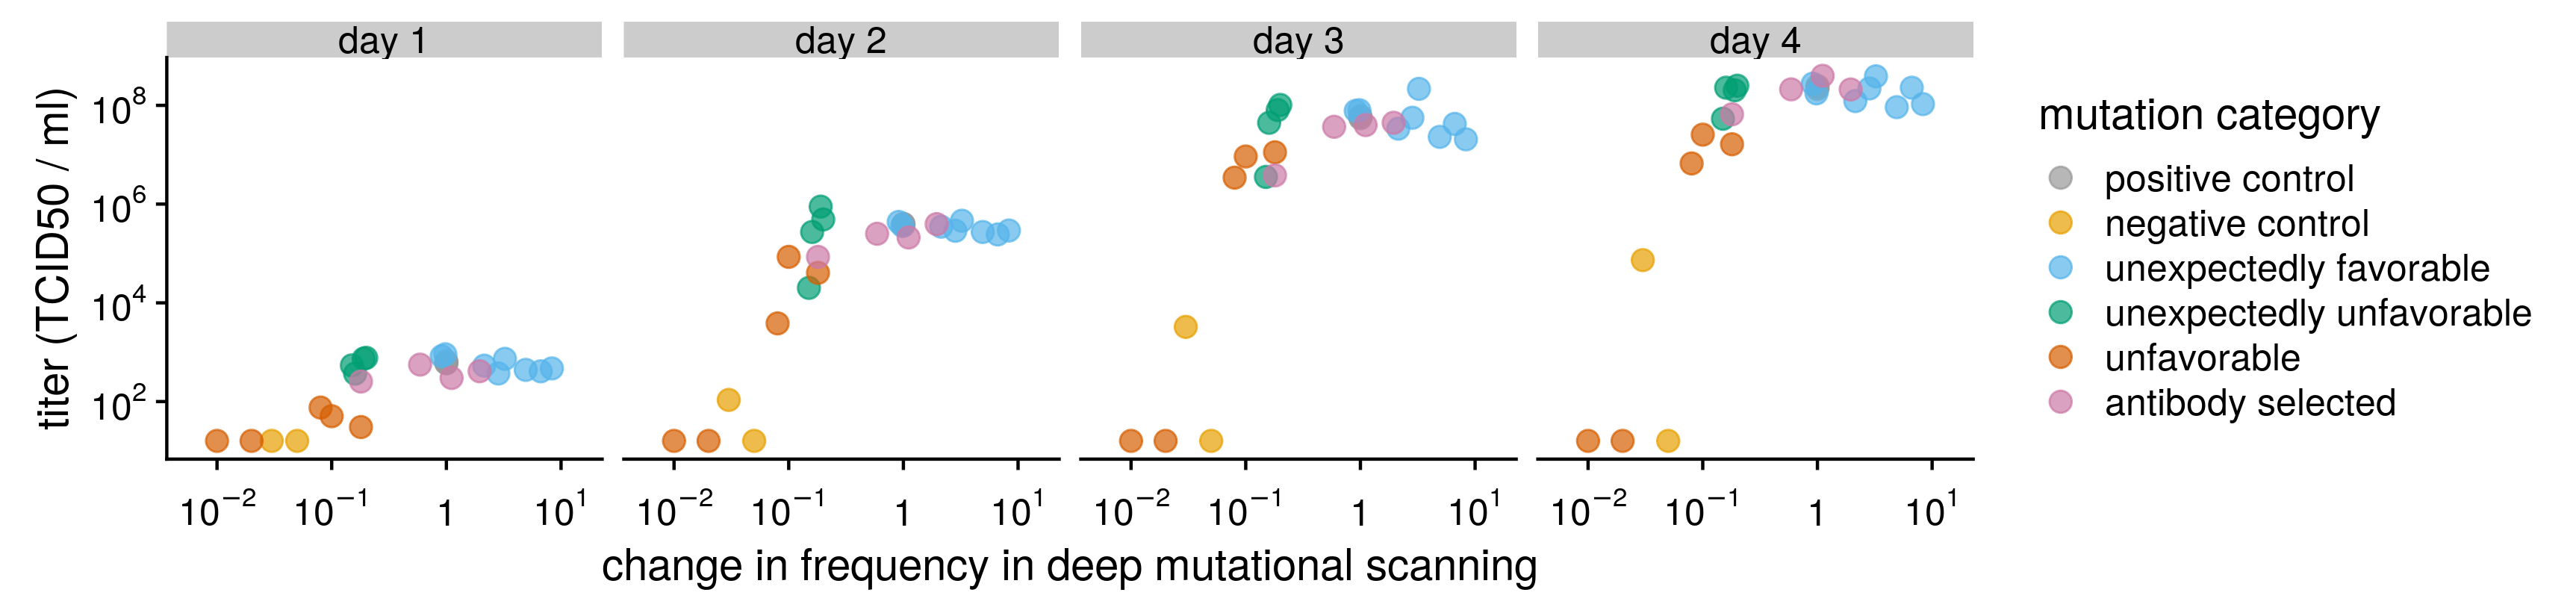

In [7]:
dms_titer_corr <- tidy_data %>%
  ggplot(aes(DMS_foldchange, titer, color=category)) +
  geom_point(size=3, alpha=0.7) +
  facet_wrap(~ day, nrow=1) +
  scale_x_log10(name="change in frequency in deep mutational scanning",
                labels=fancy_scientific,
                expand=expand_scale(0.15, 0)) +
  scale_y_log10(name="titer (TCID50 / ml)",
                labels=fancy_scientific) +
  scale_color_manual(values=cbPalette,
                     name='mutation category') +
  theme(axis.text.x=element_text(vjust=0))

saveShowPlot(dms_titer_corr, 11.5, 2.75)

Plot titers for individual samples:

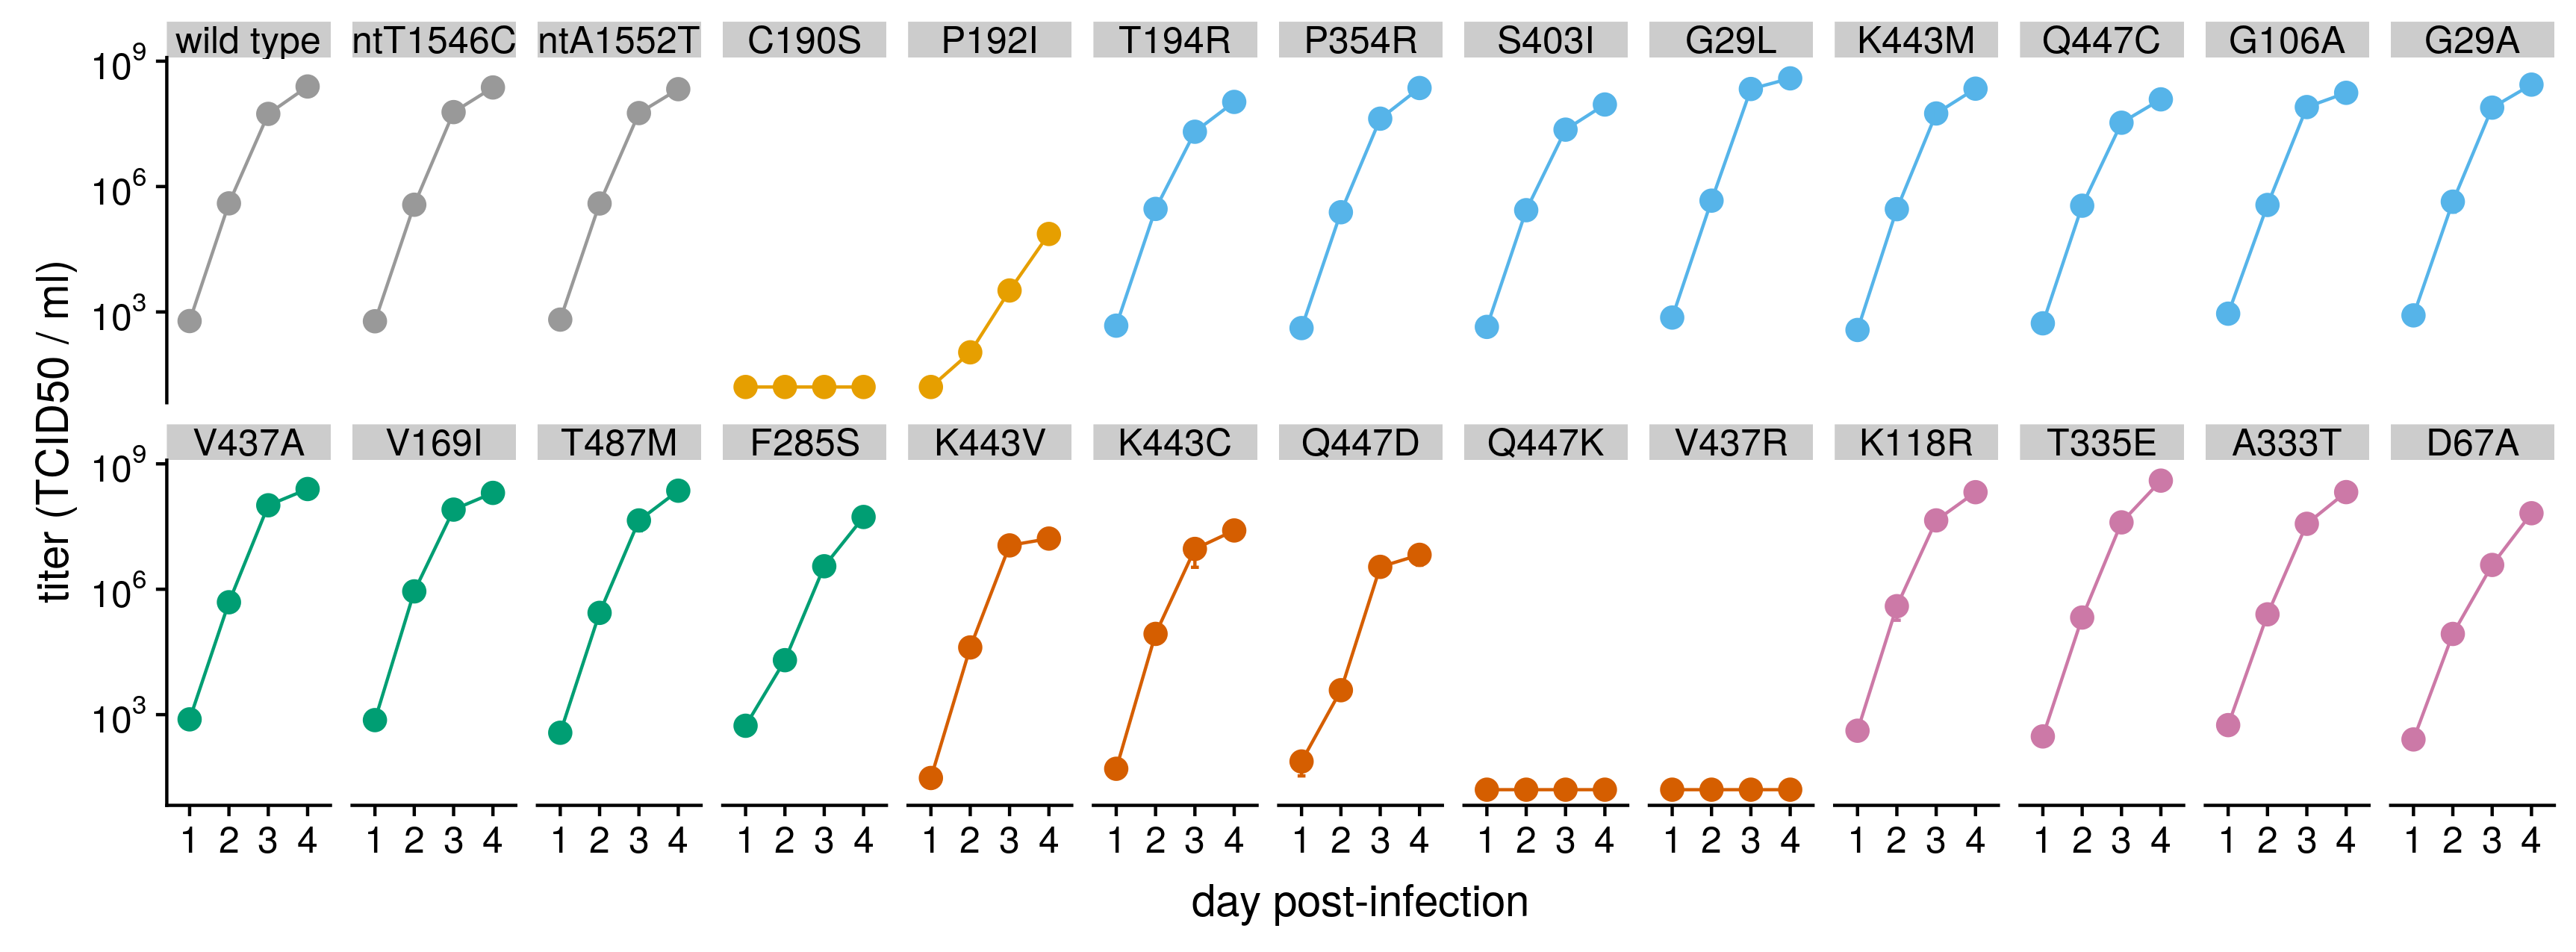

In [8]:
dms_titer_vals <- tidy_data %>%
  transform(mutation=factor(mutation, tidy_data$mutation %>% unique)) %>%
  ggplot(aes(day_num, titer, color=category)) +
  geom_point(size=3) +
  geom_line() +
  geom_errorbar(aes(ymin=titer - titer_SD, ymax=titer + titer_SD), width=0.2) +
  facet_wrap(~ mutation, ncol=13) +
  scale_y_log10(name="titer (TCID50 / ml)",
                labels=fancy_scientific) +
  scale_x_continuous(name='day post-infection',
                     expand=expand_scale(0.15, 0)) +
  scale_color_manual(values=cbPalette, guide=FALSE)

saveShowPlot(dms_titer_vals, 11.5, 4.25)

With black error bars:

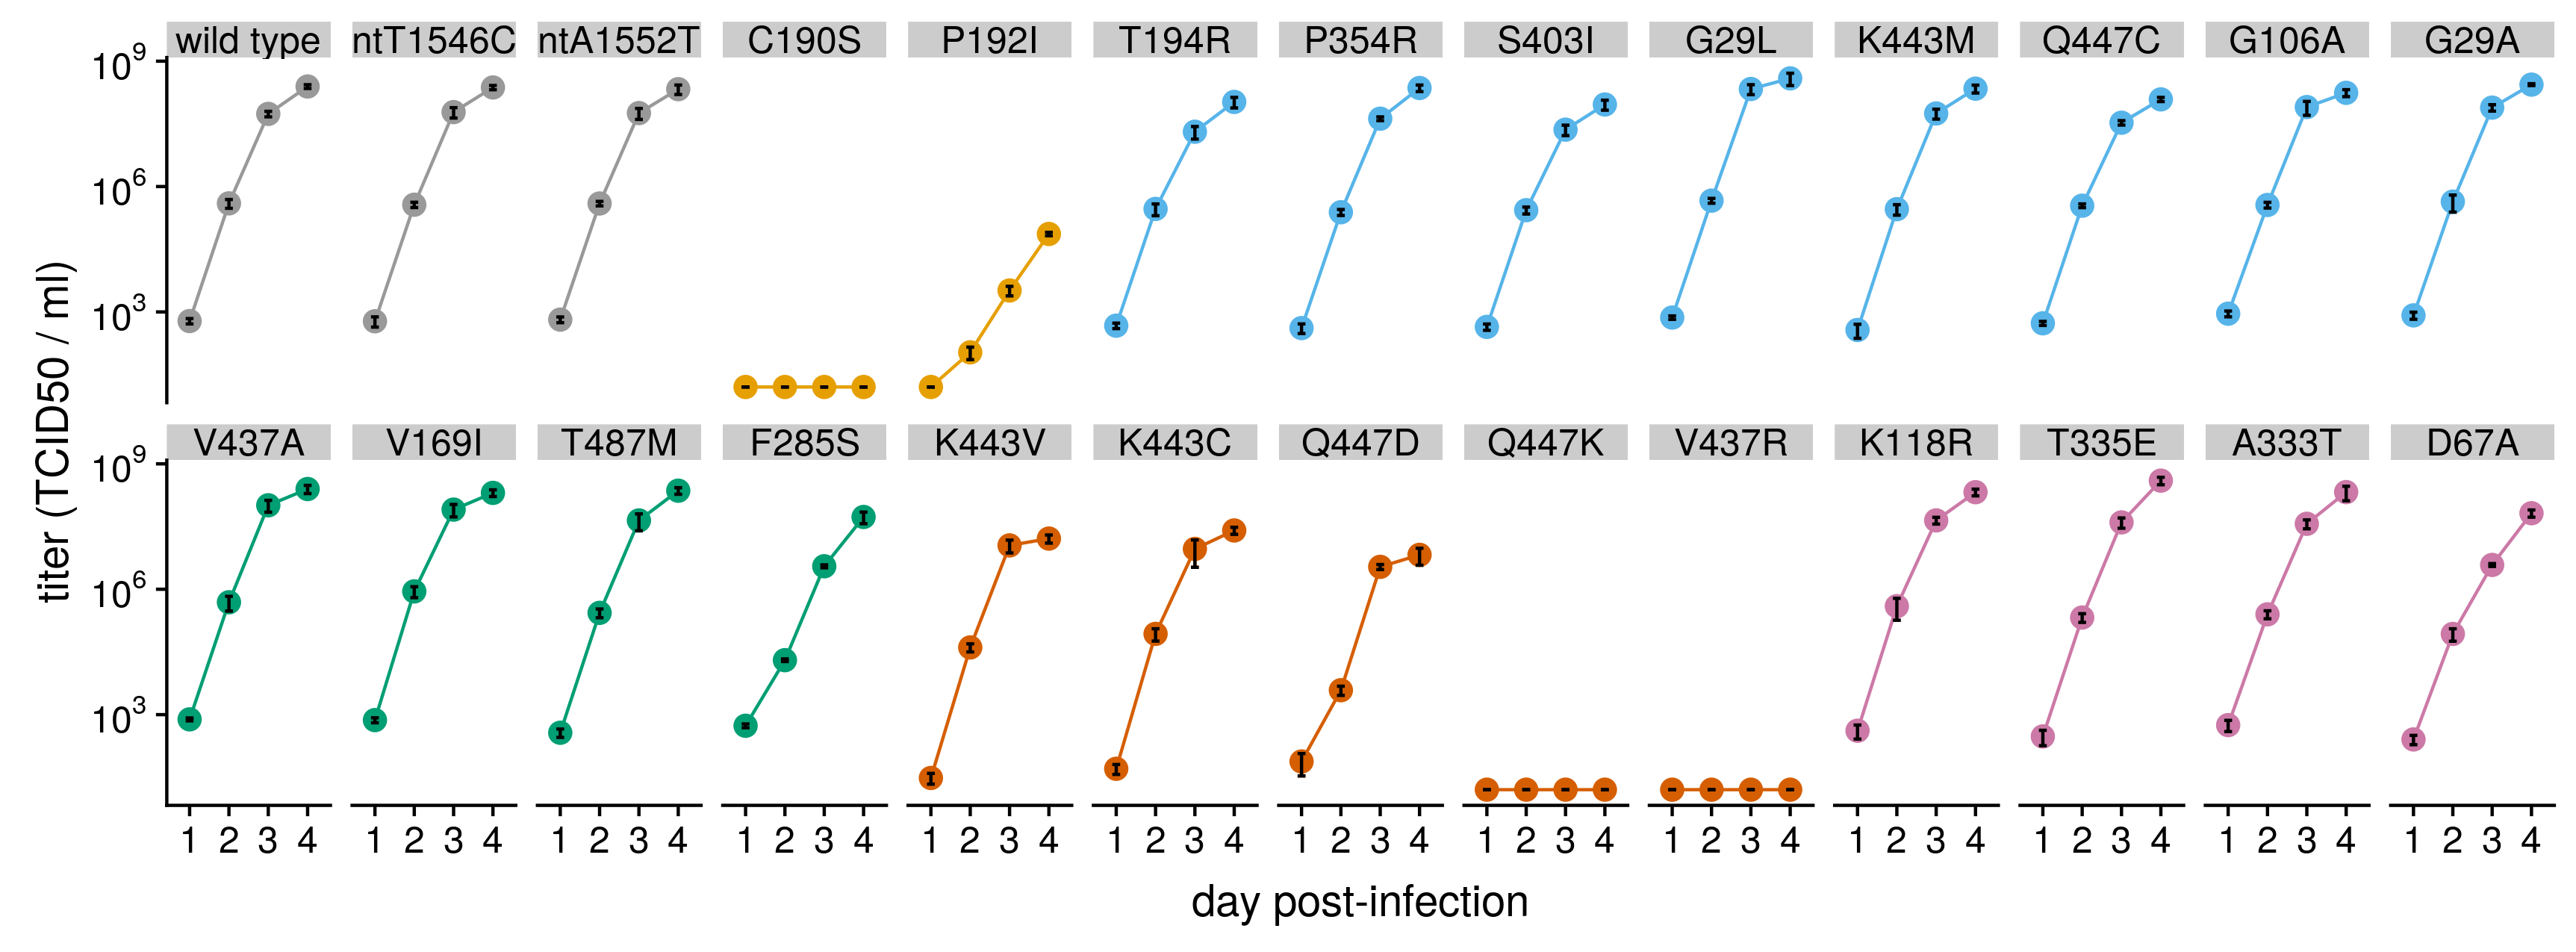

In [9]:
dms_titer_vals_black_error <- dms_titer_vals + 
  geom_errorbar(aes(ymin=titer - titer_SD, ymax=titer + titer_SD), width=0.2, color='black')

saveShowPlot(dms_titer_vals_black_error, 11.5, 4.25)

Use cowplot to arrange into a single figure:

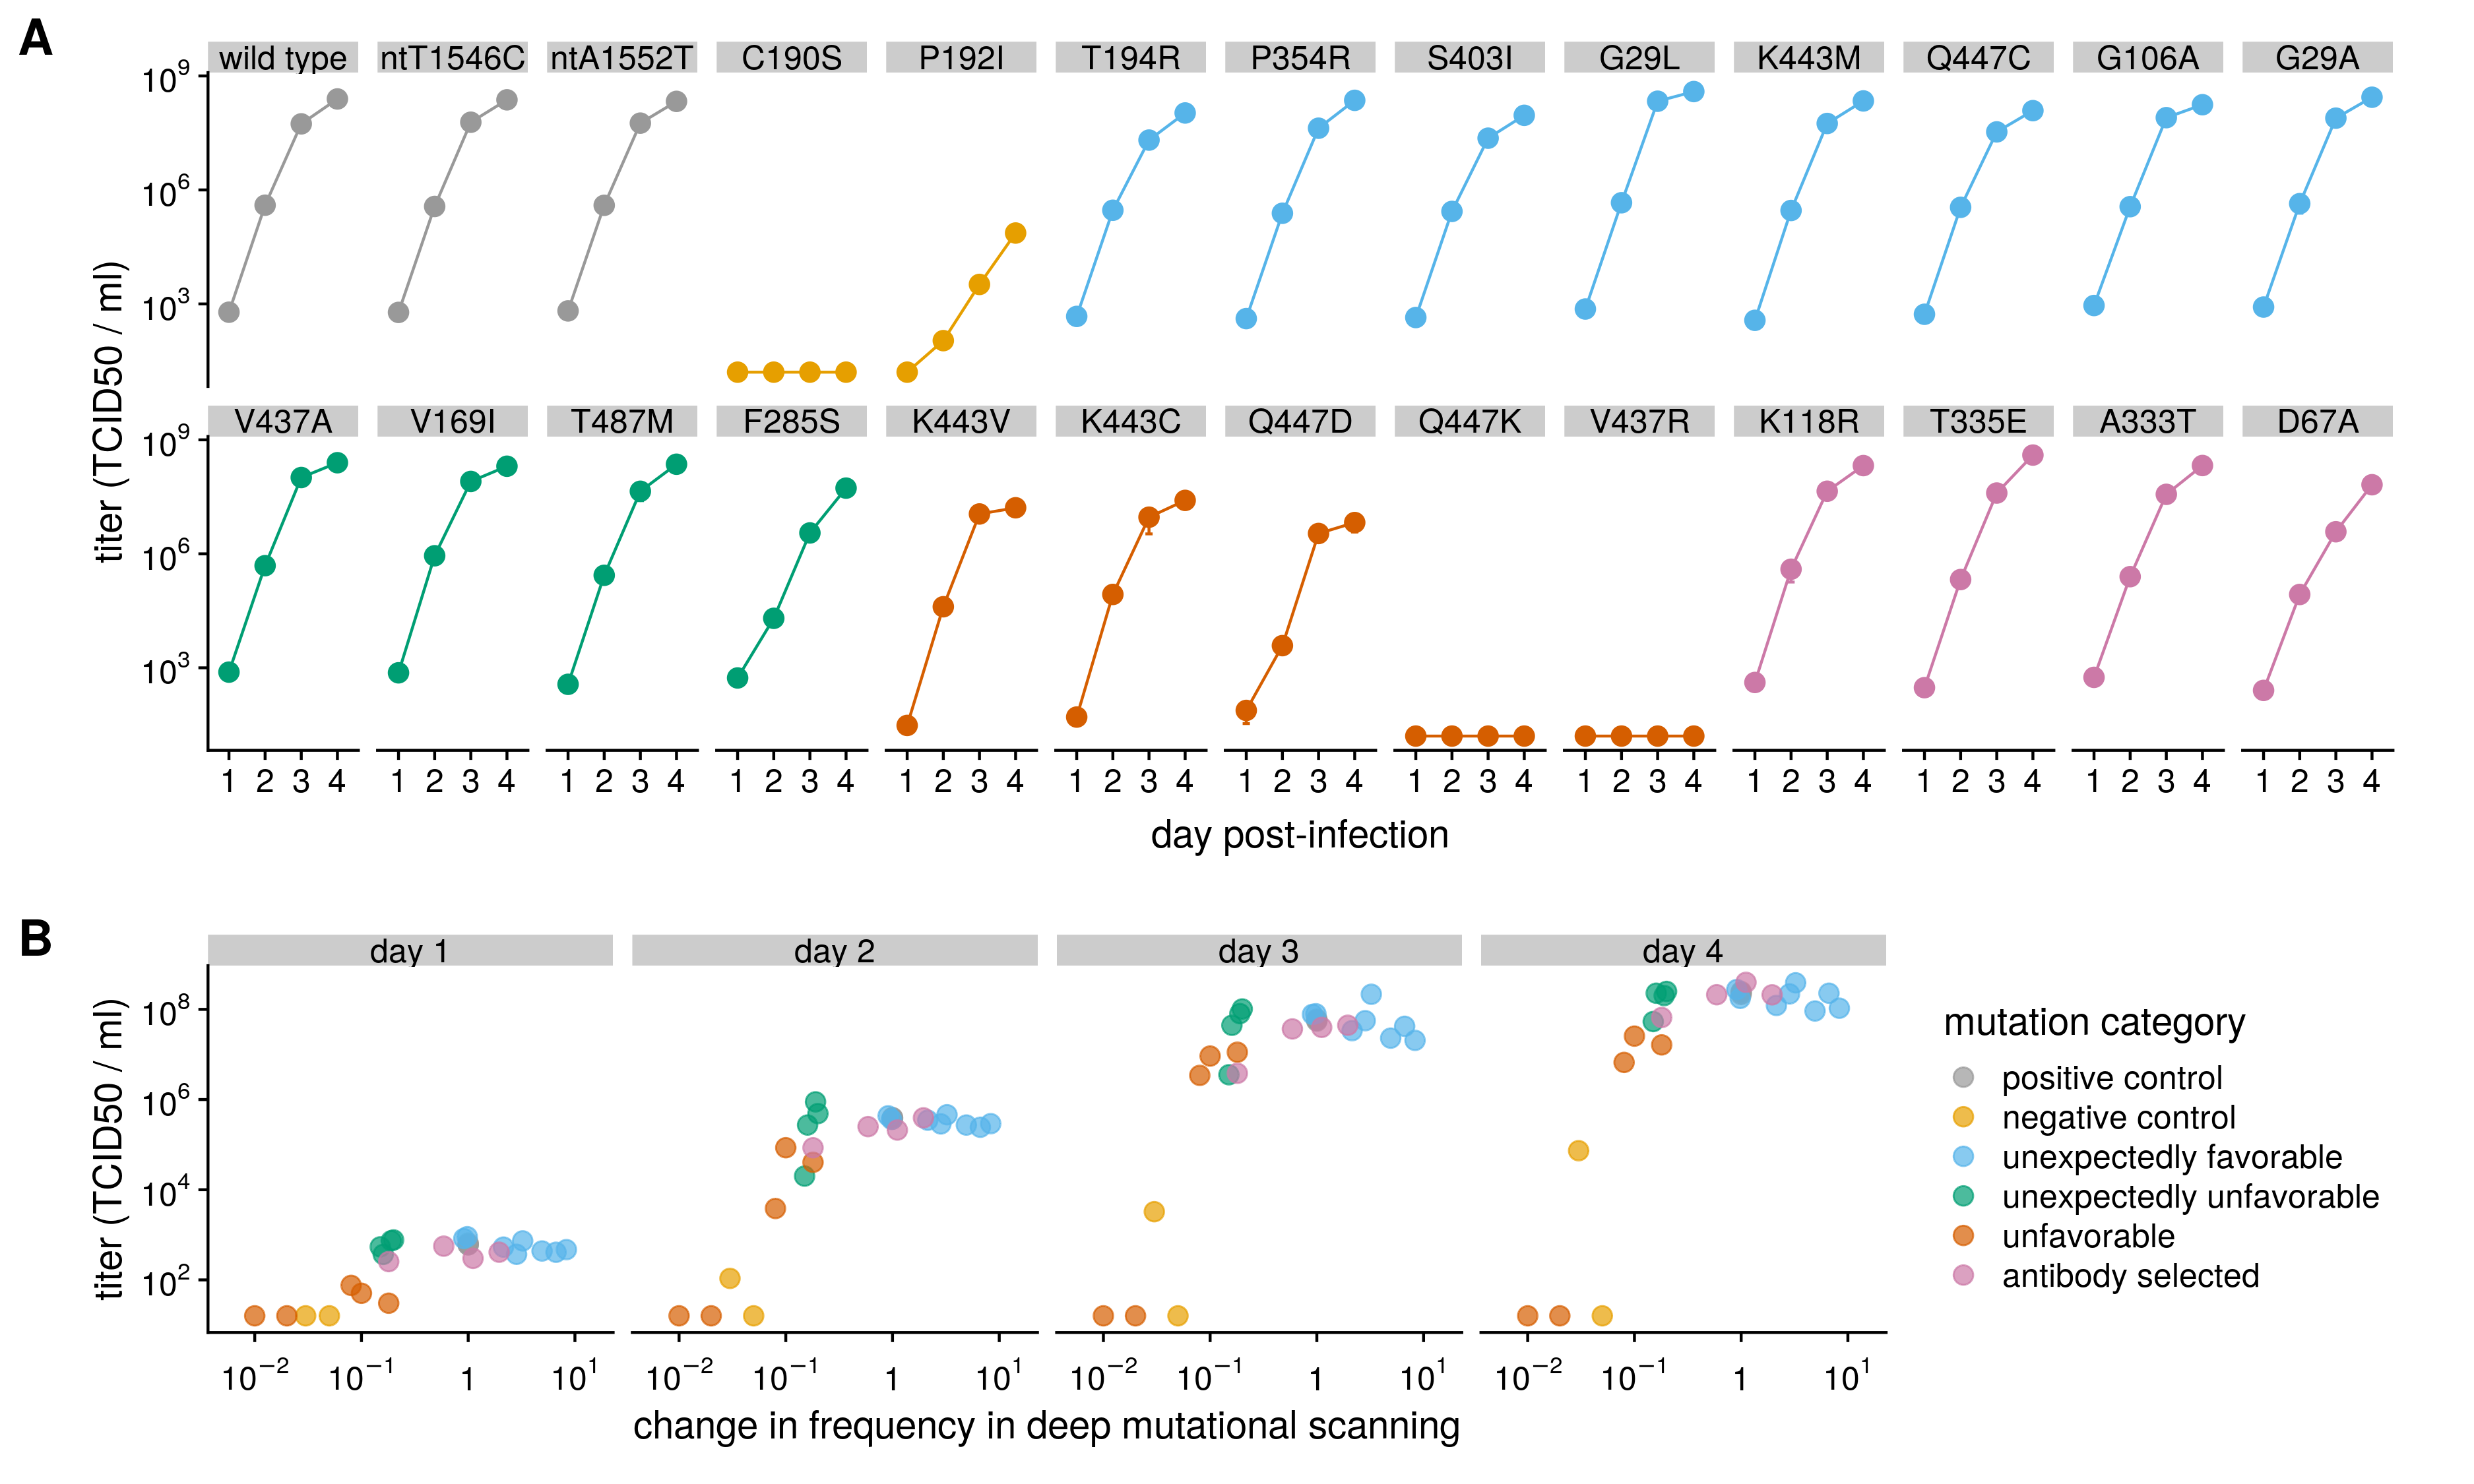

In [10]:
merged_plot <- plot_grid(
    dms_titer_vals, dms_titer_corr,
    labels=c("A", "B"), label_size=18,
    ncol=1, rel_heights=c(4.25, 2.75), scale=0.95)

saveShowPlot(merged_plot, 12.5, 7.5)

Same figure with black error bars:

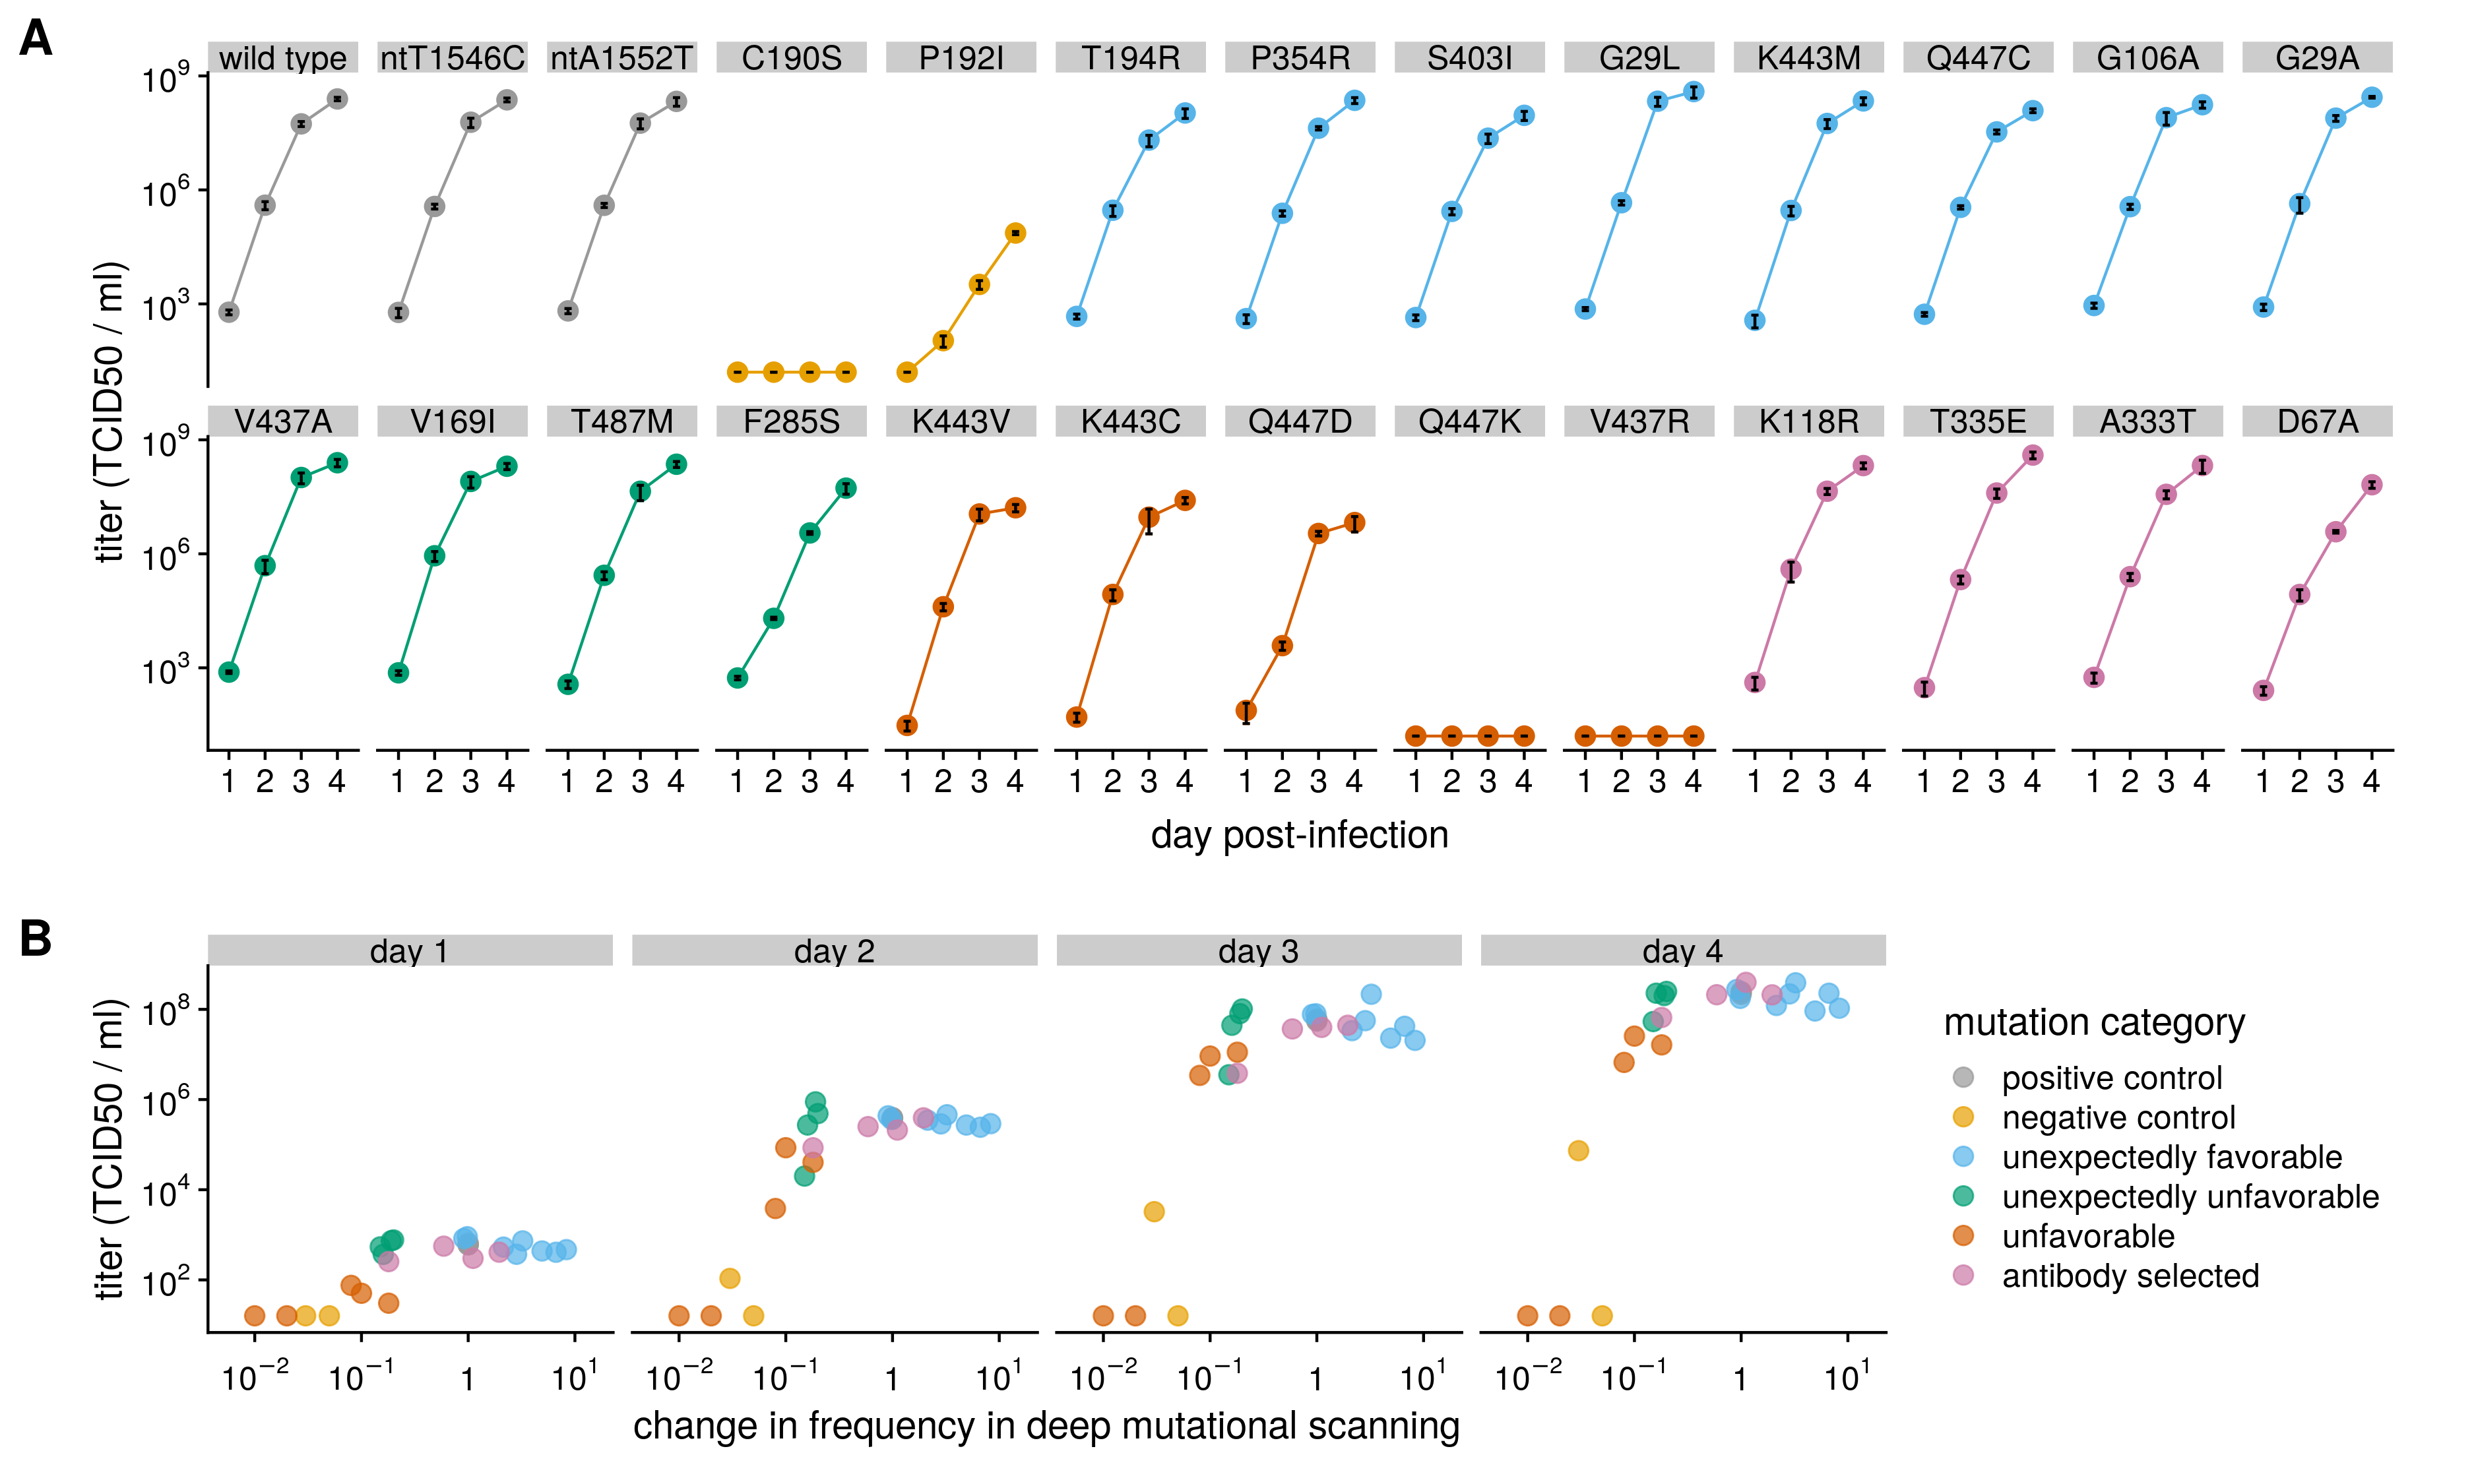

In [11]:
merged_plot_black_error <- plot_grid(
    dms_titer_vals_black_error, dms_titer_corr,
    labels=c("A", "B"), label_size=18,
    ncol=1, rel_heights=c(4.25, 2.75), scale=0.95)

saveShowPlot(merged_plot_black_error, 12.5, 7.5)